<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import warnings

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.dates as dates

import seaborn as sns
from scipy import stats as st
import re

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import (
    RandomizedSearchCV,
    GridSearchCV,
    train_test_split,
    TimeSeriesSplit,
    cross_val_score
)

from lightgbm import LGBMRegressor

import time
import datetime

pd.set_option('display.max_columns', None)

# настройки
warnings.filterwarnings("ignore")

#константы
RANDOM_STATE = 12345

## Подготовка

In [2]:
# Универсальная функция для исследования проблем датасета 
def explore_dataset(dataset):
    from IPython.display import display
    
    print('Первые пять строк датасета:')
    display(dataset.head(5))
    
    
    print('')
    print(f'Датасет имеет размер {dataset.shape[0]} строк и {dataset.shape[1]} столбцов.')
    missing_columns = dataset.isna().any()[lambda x: x]
    missing_values = dataset.isnull().sum()/len(dataset)
    missing_values = missing_values[missing_columns.keys()].sort_values(ascending = False)
    if len(missing_columns)>0:
        print(f'Из них {len(missing_columns)} столбцов имеют пропуски в данных.')
        print(f'Это столбцы: ', ', '.join(dataset.isna().any()[lambda x: x].keys()))
        print('')    
        bars = missing_values.plot(kind = 'barh', figsize=(10,round(len(missing_columns)/3)))
        plt.title('Процент пропущенных значений по столбцам')
        for i, v in enumerate(missing_values):
            plt.gca().text(v + 0.005*missing_values.max(), i - 0.1, '{:.2%}'.format(v), color='black')
        plt.show()
        plt.close()
    else:
        print('Пропусков в данных нет')
        
        
    if len(dataset[dataset.duplicated()])>0:
        print(f'В датасете содержится {len(dataset[dataset.duplicated()])} дубликатов')
    else:
        print('В данных не найдено полных дубликатов.')
        
        
    print('')
    print('Столбцы имеют следующие типы данных:')    
    print(dataset.dtypes)
    
    
    print('')
    print('Общая статистика по количественным переменным:')    
    display(dataset.describe())
    print('')
    print('Общая статистика по категориальным переменным:')    
    display(dataset.describe(include=["object", "bool"]))
    
    print('')
    print('Распределение и выбросы данных в количественных переменных:')    
    dataset.plot.box(subplots=True, 
                     layout=(1,len(dataset.select_dtypes(exclude=['object','bool']).columns)), 
                     vert='False',
                     figsize=(2.5*len(dataset.select_dtypes(exclude=['object','bool']).columns),8));
    plt.show()
    plt.close()
    return

In [3]:
data = pd.read_csv('/datasets/taxi.csv') 

Первые пять строк датасета:


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32



Датасет имеет размер 26496 строк и 2 столбцов.
Пропусков в данных нет
В данных не найдено полных дубликатов.

Столбцы имеют следующие типы данных:
datetime      object
num_orders     int64
dtype: object

Общая статистика по количественным переменным:


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000



Общая статистика по категориальным переменным:


,datetime
count,26496
unique,26496
top,2018-03-18 19:00:00
freq,1



Распределение и выбросы данных в количественных переменных:


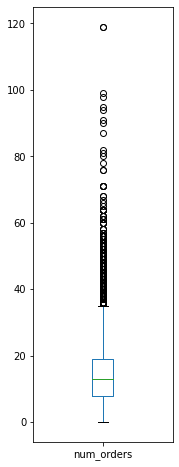

In [4]:
explore_dataset(data)

В данных нет пропусков, дубликатов и аномалий, преобразуем колонку со временем в тип datetime и сделаем ее индексами:


In [5]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)


Проверим индексы на монотонность:

In [6]:
data.index.is_monotonic

True

In [7]:
# Посмотрим на начальную и конечную даты наблюдений

print('Дата начала наблюдений: {}'.format(data.index.min()))
print('Дата окончания наблюдений: {}'.format(data.index.max()))
print('Временной отрезок: {}'.format(data.index.max() - data.index.min()))

Дата начала наблюдений: 2018-03-01 00:00:00
Дата окончания наблюдений: 2018-08-31 23:50:00
Временной отрезок: 183 days 23:50:00


Данные содержат в себе 184 дня измерений количества заказов такси с 10 минутным интервалом с 1го марта по 31ое августа 2018 года. Проведем ресемплирование данных по часам:

In [8]:
data = data.resample('1H').sum()
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Данные подготовлены, ресемплирование проведено, перейдем к анализу данных.

## Анализ

Посмотрим на график изменения количества заказов со временем:

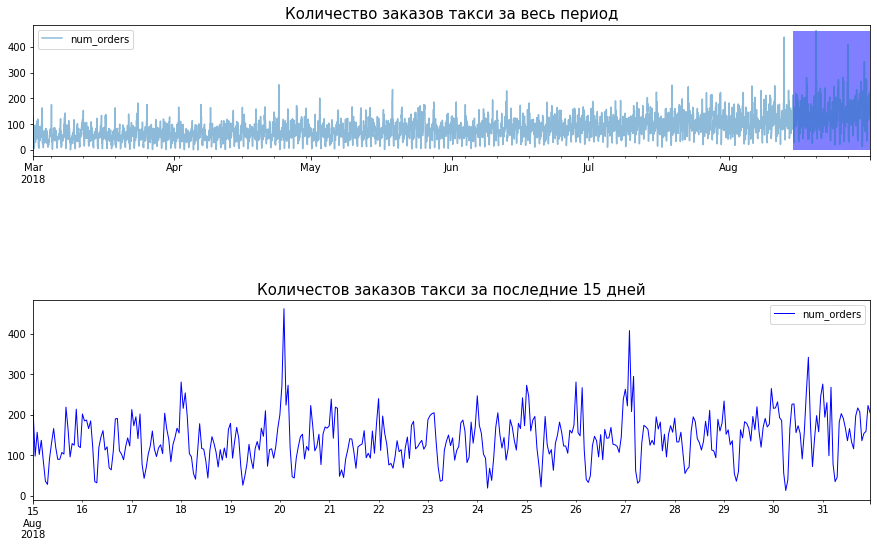

In [9]:
zoom = ('2018-08-15 00:00:00','2018-09-01 00:00:00')

fig = plt.figure(figsize=(15, 10))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.1, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

data.plot(ax=main_ax, alpha=0.5)
min_y = min(data['num_orders'])
max_y = max(data['num_orders'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
data.loc[zoom[0]: zoom[1]].plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Количество заказов такси за весь период', fontsize=15)
zoom_ax.set_title(f'Количестов заказов такси за последние 15 дней', fontsize=15)
zoom_ax.set_xlabel('');
plt.tight_layout()

По такому графику не многое можно сказать, однако можно отметить что в августе присутствуют некоторые выбросы значений, не наблюдающиеся в остальные месяцы. Возможно они имеют недельную сезонность и привязаны к выходным. Попробуем разложить временной ряд на тренд, сезонную составляющую и остатки:

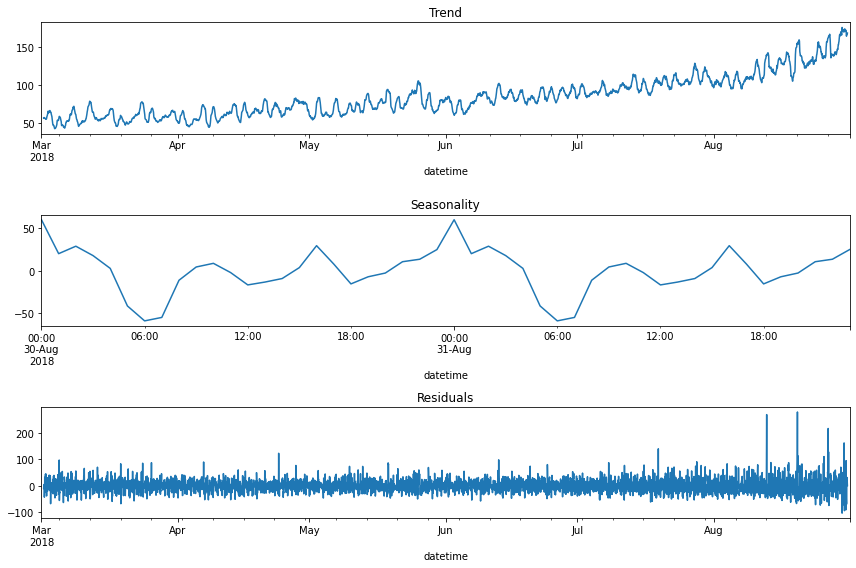

In [10]:
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.tail(48).plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Из гравиков выше видно, что имеется тренд на возрастание количества заказов от марта к августу. Так же имеется четко выраженный суточный ход количества заказов: пик заказов приходится на полночь а минимум на 6 утра.
Ресемплирование по часу позволило проанализировать суточный ход временного ряда, однако на графике тренда видны колебания большего временного периода, которые не были выделены. Попробуем повторить разложение для данных ресемплированных на 1 сутки:

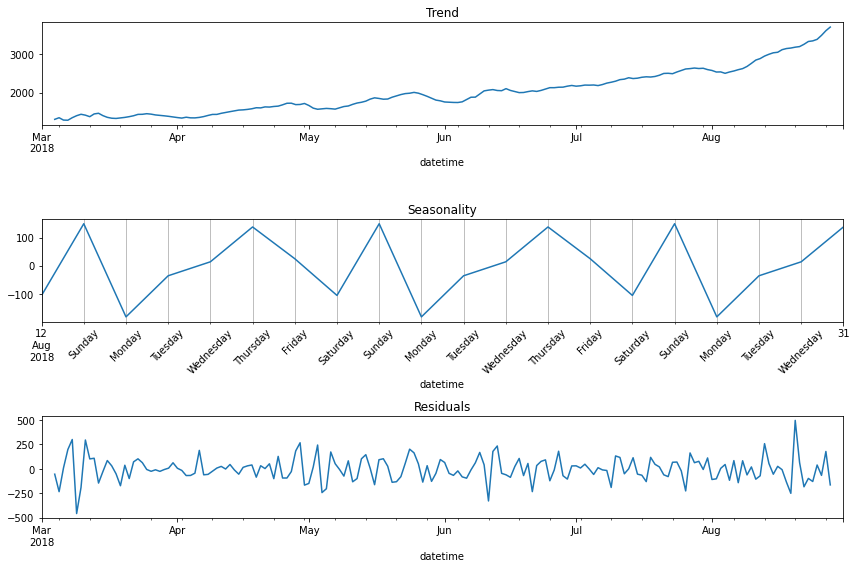

In [11]:


decomposed = seasonal_decompose(data.resample('1D').sum())  

plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.tail(20).plot(ax=plt.gca())
plt.gca().xaxis.grid(True, which='both')
plt.gca().set_xticklabels(decomposed.seasonal.tail(20).index.day_name(), minor=True)
plt.gca().tick_params(axis='x', which='minor', rotation=45)

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


Мы получили более гладкую линию тренда и выделили недельные колебания данных. Максимумы заказов такси приходятся на воскресенье и четверг в понедельник и субботу. 

Вполне возможно что в сфере такси имеется сезонность по месяцам и годам, однако из имеющихся данных такие сезонности выделить невозможно.

Таким образом мы проаналbзировали данные и выявили тренд увеличения заказов такси от марта к августу, а также выделили суточную и недельную сезонность в данных. Таким образом, важными признаками для модели будут календарные признаки, такие как:

- час
- день недели.

А так же отстающие признаки и скользящее среднее, для вычисления тренда.

Чтобы понять какие отстающие признаки будут полезными, построим график частичной атокорреляции:


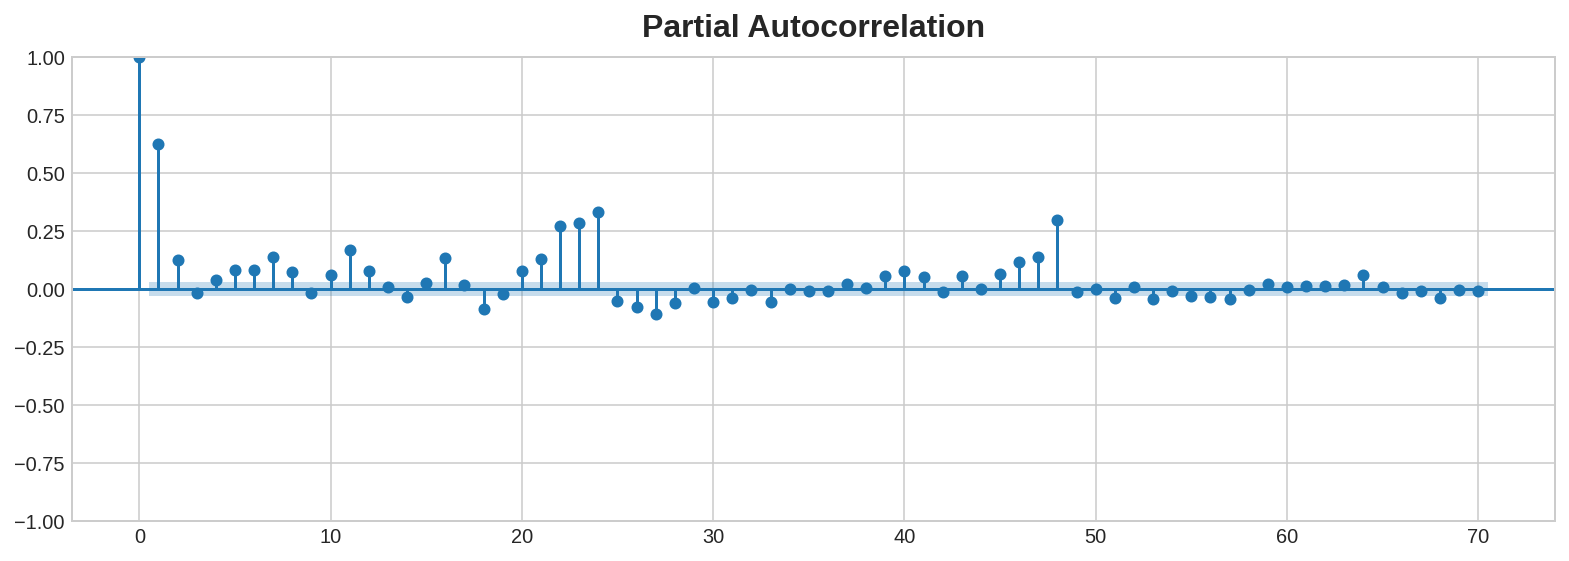

In [12]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'
_ = plot_pacf(data['num_orders'], lags=70)

График показывает значимость многих лагов, однако выделим из них лаги с самыми большими значениями:
    
    - лаг на 1 показывает, что количество заказов во многом определяется количеством в предыдущий час
    - лаги на 22, 23, 24 и 48 определяются суточной сезонностью данных: например, ночью порядок заказов будет схожим с предыдущей ночью, или ночью двумя днями ранее
    - лаги на 5,6,7 тоже показывают значимые значения и позволяют модели больше адаптироваться к ситуации с заказами в конкретный день.
    
Эти лаги мы будем использовать при создании новых признаков модели.

In [13]:
lags=[1,2,5,6,7,22,23,24,48]

Чтобы определить оптимальный размер окна скользящего среднего воспользуемся моделью линейной регрессии и посмотрим при каком значении она дает наилучший результат на обучающих данных.

Для этого сначала определим функцию для подготовки данных, которая будет добавлять новые признаки в данные и делить выборку на обучающую и тестовую в соотношении 9 к 1:

In [14]:
def prepare_data(data, lags, rolling_mean_size):
    new_data= data.copy()
#     new_data['year'] = new_data.index.year
#     new_data['month'] = new_data.index.month
#     new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    
    for lag in lags:
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)
        

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    train, test = train_test_split(new_data, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
    train = train.dropna()

    features_train = train.drop('num_orders', axis=1)
    features_test = test.drop('num_orders', axis=1)
    target_train = train['num_orders']
    target_test = test['num_orders']

    return features_train, features_test, target_train, target_test

Обучим модель в цикле для различных значений окна скользящего среднего в диапазоне от 1 до 24х14 (2 недели), в качестве метрики качества возьмем RMSE:

In [15]:
rmse_train=[]
for window in range(1,24*14):
    
    features_train, features_test, target_train, target_test = prepare_data(data, lags, window)
    
    model = LinearRegression()
    cv = TimeSeriesSplit(n_splits=2) 
    scores = cross_val_score(model, features_train, target_train, 
                             cv=cv, scoring='neg_root_mean_squared_error')
    final_score = scores.mean()

    rmse_train.append(final_score)


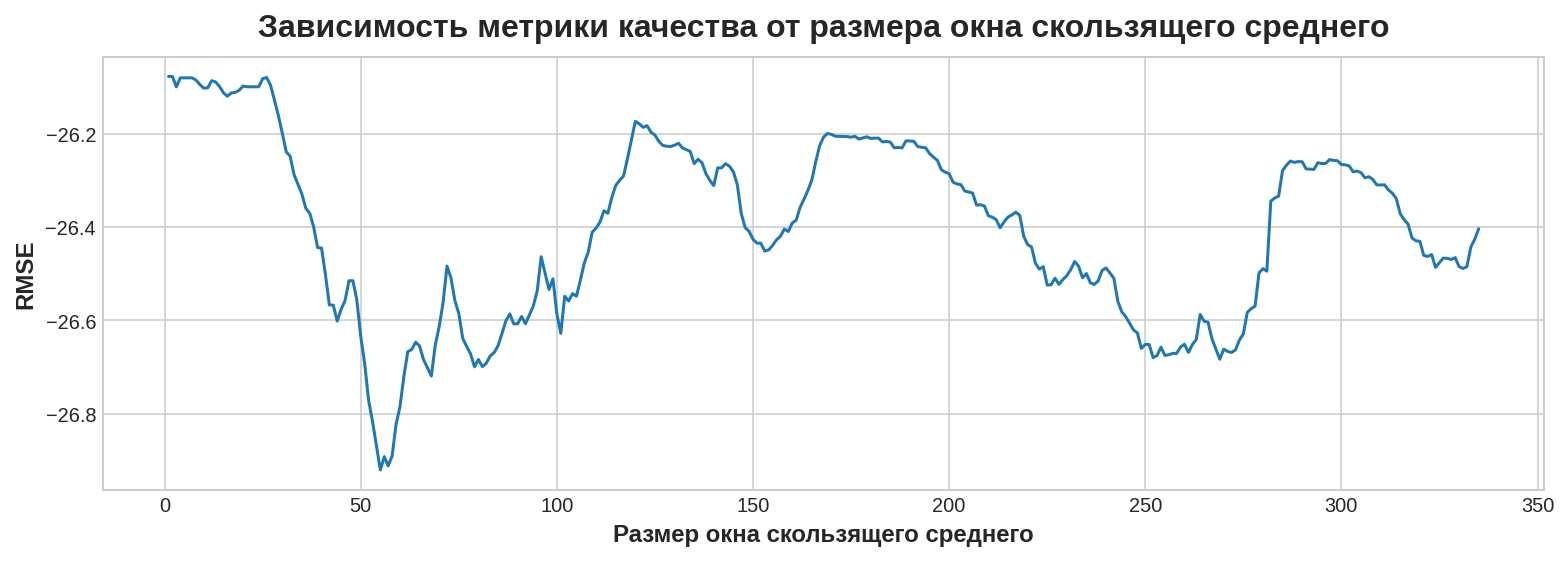

In [16]:
plt.plot(range(1,24*14), rmse_train)
plt.title('Зависимость метрики качества от размера окна скользящего среднего')
plt.xlabel('Размер окна скользящего среднего')
plt.ylabel('RMSE');

In [17]:
print('Оптимальный размер окна скользящего среднего:',np.argmin(rmse_train)+1)

Оптимальный размер окна скользящего среднего: 55


Наилучший результат мы получили при окне равном 55 часов. Зафиксируем это число и перейдем к подбору модели.

## Обучение

Подготовим данные с учетом оптимальных параметров:

In [18]:
features_train, features_test, target_train, target_test = prepare_data(data, lags, np.argmin(rmse_train)+1)
print('Размер обучающей выборки:', features_train.shape[0])
print('Размер тестовой выборки:', features_test.shape[0])

Размер обучающей выборки: 3919
Размер тестовой выборки: 442


In [19]:
print('Дата начала наблюдений в обучающей выборке: {}'.format(features_train.index.min()))
print('Дата окончания наблюдений в обучающей выборке: {}'.format(features_train.index.max()))
print('Дата начала наблюдений в тестовой выборке: {}'.format(features_test.index.min()))
print('Дата окончания наблюдений в тестовой выборке: {}'.format(features_test.index.max()))

Дата начала наблюдений в обучающей выборке: 2018-03-03 07:00:00
Дата окончания наблюдений в обучающей выборке: 2018-08-13 13:00:00
Дата начала наблюдений в тестовой выборке: 2018-08-13 14:00:00
Дата окончания наблюдений в тестовой выборке: 2018-08-31 23:00:00


### Линейная регрессия

Снова обучим модель линейной регрессии и зафиксируем метрику качества.

In [20]:

model_lr = LinearRegression()
cv = TimeSeriesSplit(n_splits=3) 
scores = cross_val_score(model, features_train, target_train, 
                         cv=cv, scoring='neg_root_mean_squared_error')

model_lr.fit(features_train, target_train)
pred_train_lr = model_lr.predict(features_train)
rmse_lr = abs(scores.mean())
print("RMSE обучающей выборки:", rmse_lr)

RMSE обучающей выборки: 26.45322605719036


Для оценки работы модели посмотрим сравнение результата моедлирования с фактическими данными из обучающей выборки для последних двух недель обучающей выборки:

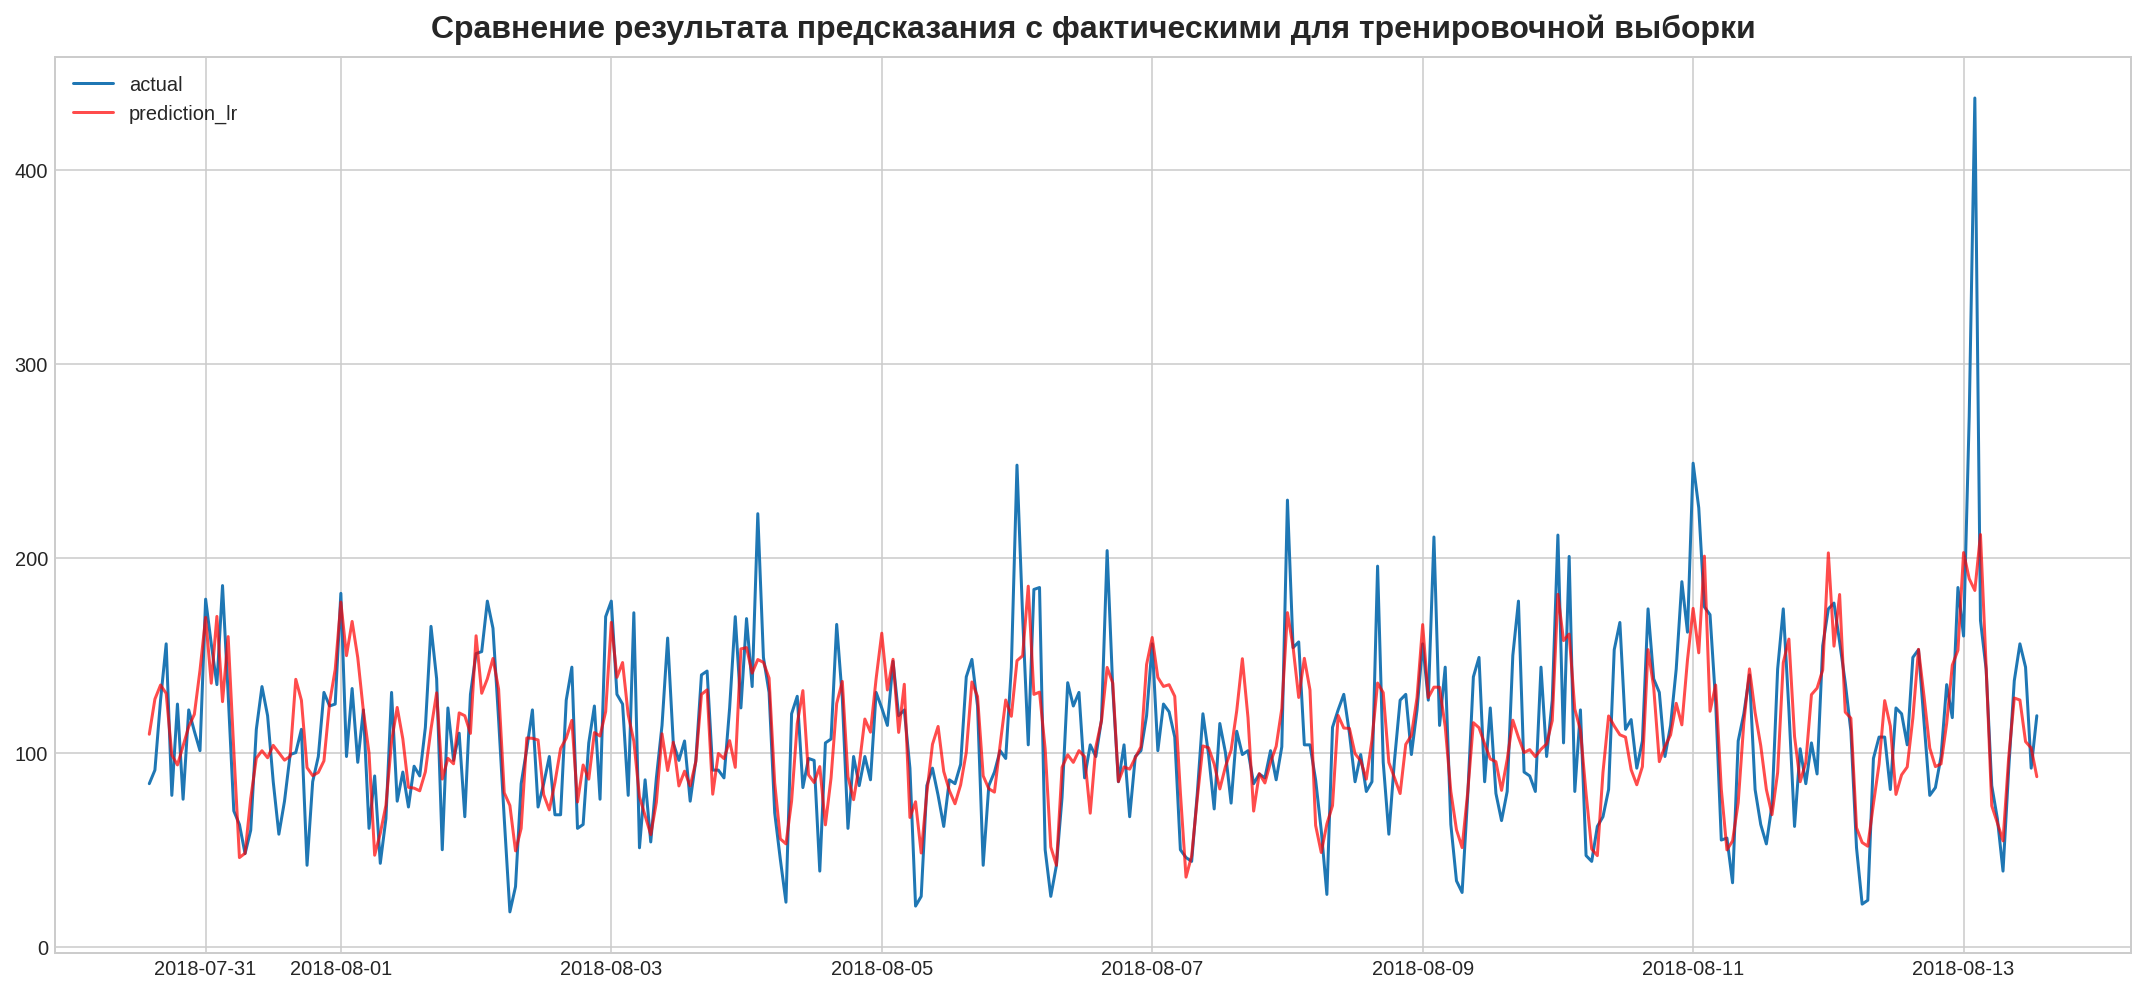

In [21]:
tail = 24*7*2
plt.figure(figsize=(15, 7))
plt.plot(features_train.tail(tail).index, target_train.values[-tail:], label="actual")
plt.plot(features_train.tail(tail).index, pred_train_lr[-tail:], "r", label="prediction_lr", alpha=0.7)
plt.legend(loc="best")
plt.title("Сравнение результата предсказания с фактическими для тренировочной выборки")
plt.grid(True);

Как мы видим из результатов, модель не всегда корректно воспроизводит суточные колебания количества заказов, а уловить выбросы и вовсе не способна, поскольку они на данном этапе носят случайный характер. 
Попробуем сравнить результат моделирования с временным рядом избавленным от случайных остатков (тренд+сезонность):

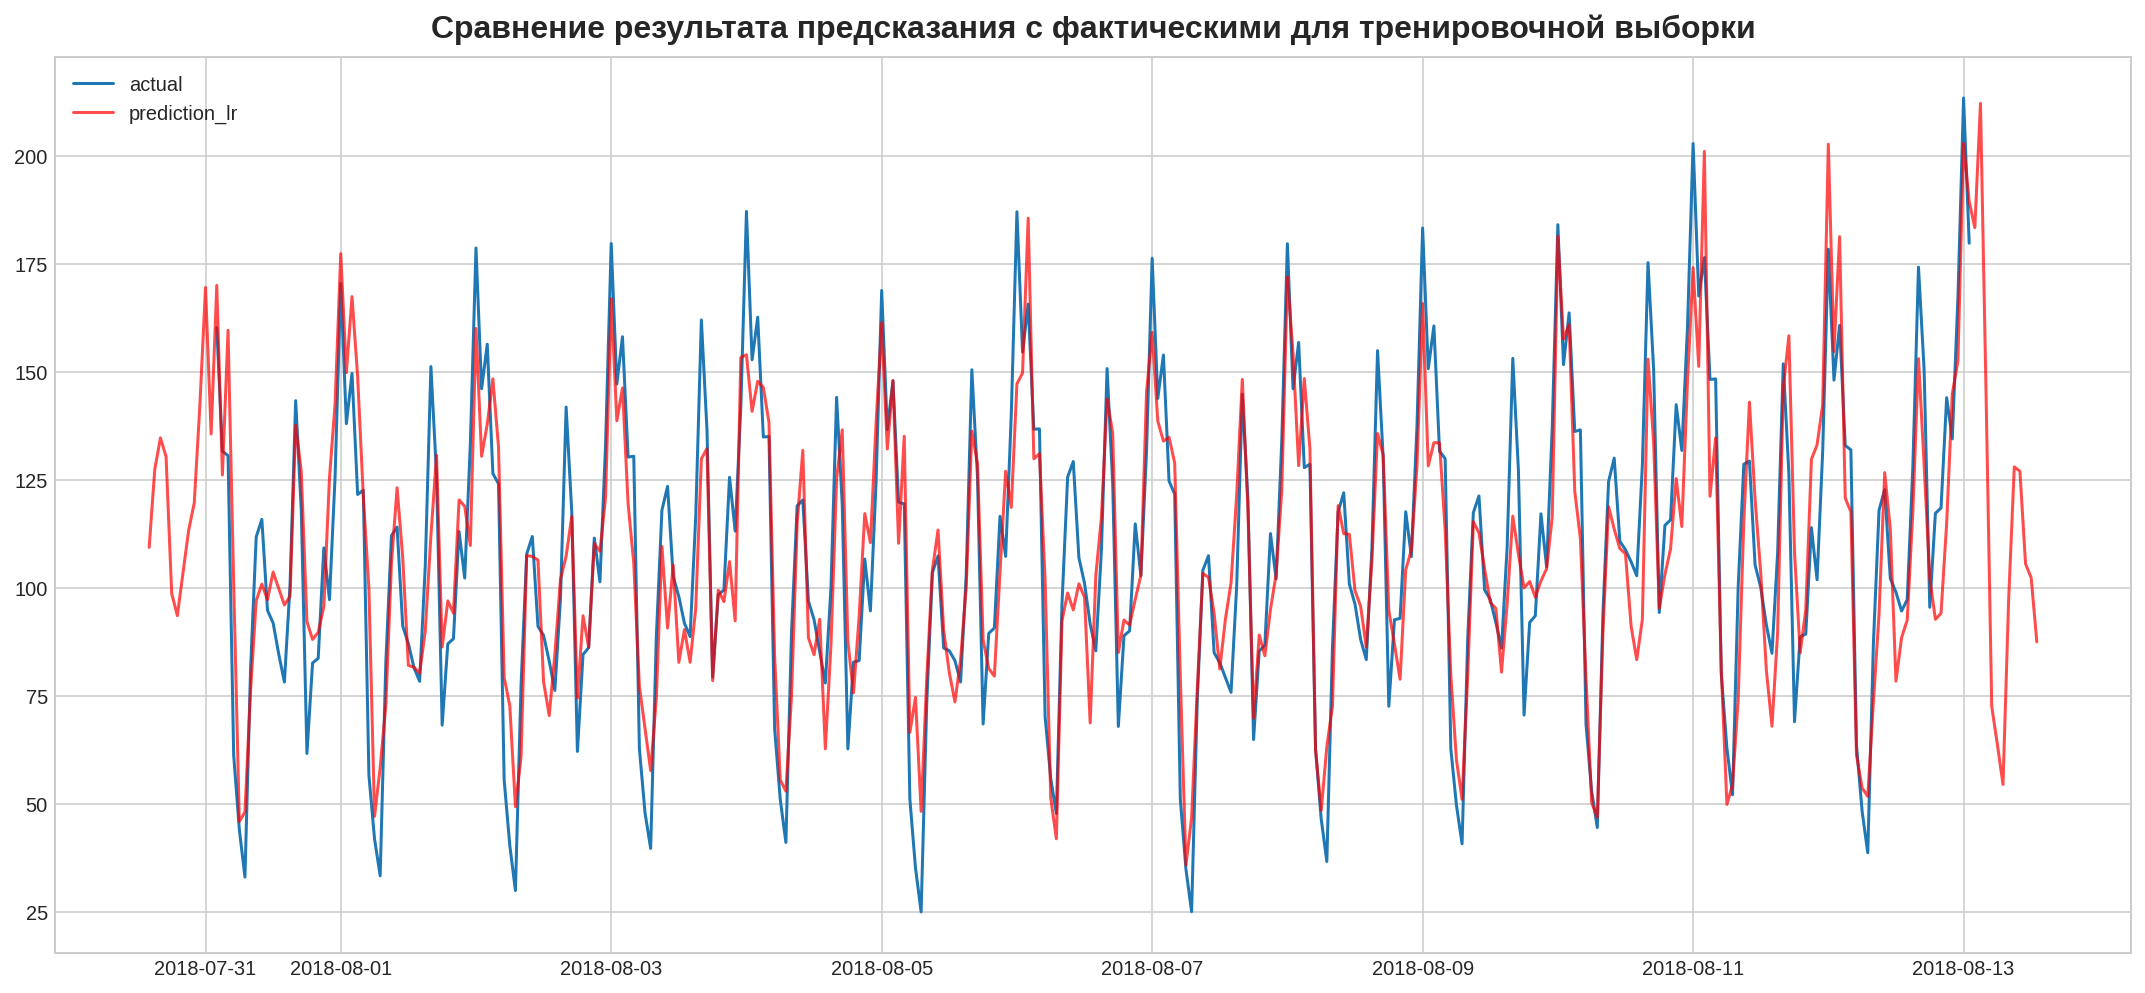

In [22]:
tail = 24*7*2
plt.figure(figsize=(15, 7))
decomposed = seasonal_decompose(pd.DataFrame(target_train.values[-tail:], 
                                             index=features_train.tail(tail).index))
plt.plot(decomposed.trend.index, decomposed.trend + decomposed.seasonal, label="actual")
plt.plot(features_train.tail(tail).index, pred_train_lr[-tail:], "r", label="prediction_lr", alpha=0.7)
plt.legend(loc="best")
plt.title("Сравнение результата предсказания с фактическими для тренировочной выборки")
plt.grid(True);

Результат стал получше, но все еще есть несоответствия.

### Случайный лес

Попробуем найти гиперпараметры для случайного леса. Метрику будем оценивать кросс-валидацией, для разбиения на подвыборки используем метод TimeSeriesSplit()


In [23]:
def tune_model_rf(features, target):
    
    clf = RandomForestRegressor(random_state=RANDOM_STATE)

    param = {}
    param['preprocessing'] =  [None]
    param['classifier__n_estimators'] =  list(np.arange(1, 201, step=50)) + [None]
    param['classifier__max_depth'] =  list(np.arange(1, 11, step=5)) + [None]
    param['classifier__criterion'] =  ['mse']
    param['classifier__max_features'] =  ['auto','sqrt','log2']
    param['classifier__min_samples_leaf'] =    [2,4]
    param['classifier__min_samples_split'] =   [2,5,10]
    param['classifier'] = [clf]   

    pipeline = Pipeline([('preprocessing', None),
                         ('classifier', clf)])
    params = [param]
    
    cv = TimeSeriesSplit(n_splits=3) 
    grid =  GridSearchCV(pipeline,
                               param_grid=params,
                               scoring='neg_root_mean_squared_error',
#                                n_iter=6,
                               cv=cv,
#                                random_state=RANDOM_STATE,
                               refit=True,
                               verbose=1)

    grid.fit(features, target)

    print('Параметры наилучшей модели:')
    print("\n".join(f'{k} : {v}' for k,v in grid.best_params_.items()))
    print("Мера RMSE для наилучшей модели:", abs(grid.best_score_))

    return grid.best_estimator_, abs(grid.best_score_)

In [24]:
start = time.time()

model_rf, rmse_rf = tune_model_rf(features_train, target_train)

end = time.time()
print('Время исполнения кода: ', time.strftime("%H:%M:%S",time.gmtime(end-start)))

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Параметры наилучшей модели:
classifier : RandomForestRegressor(max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=151,
                      random_state=12345)
classifier__criterion : mse
classifier__max_depth : None
classifier__max_features : sqrt
classifier__min_samples_leaf : 2
classifier__min_samples_split : 5
classifier__n_estimators : 151
preprocessing : None
Мера RMSE для наилучшей модели: 25.776036853235095
Время исполнения кода:  00:02:49


Метрика RMSE получилась лучше чем у модели линейной регресии. Посмотрим визуально на результат моделирования:

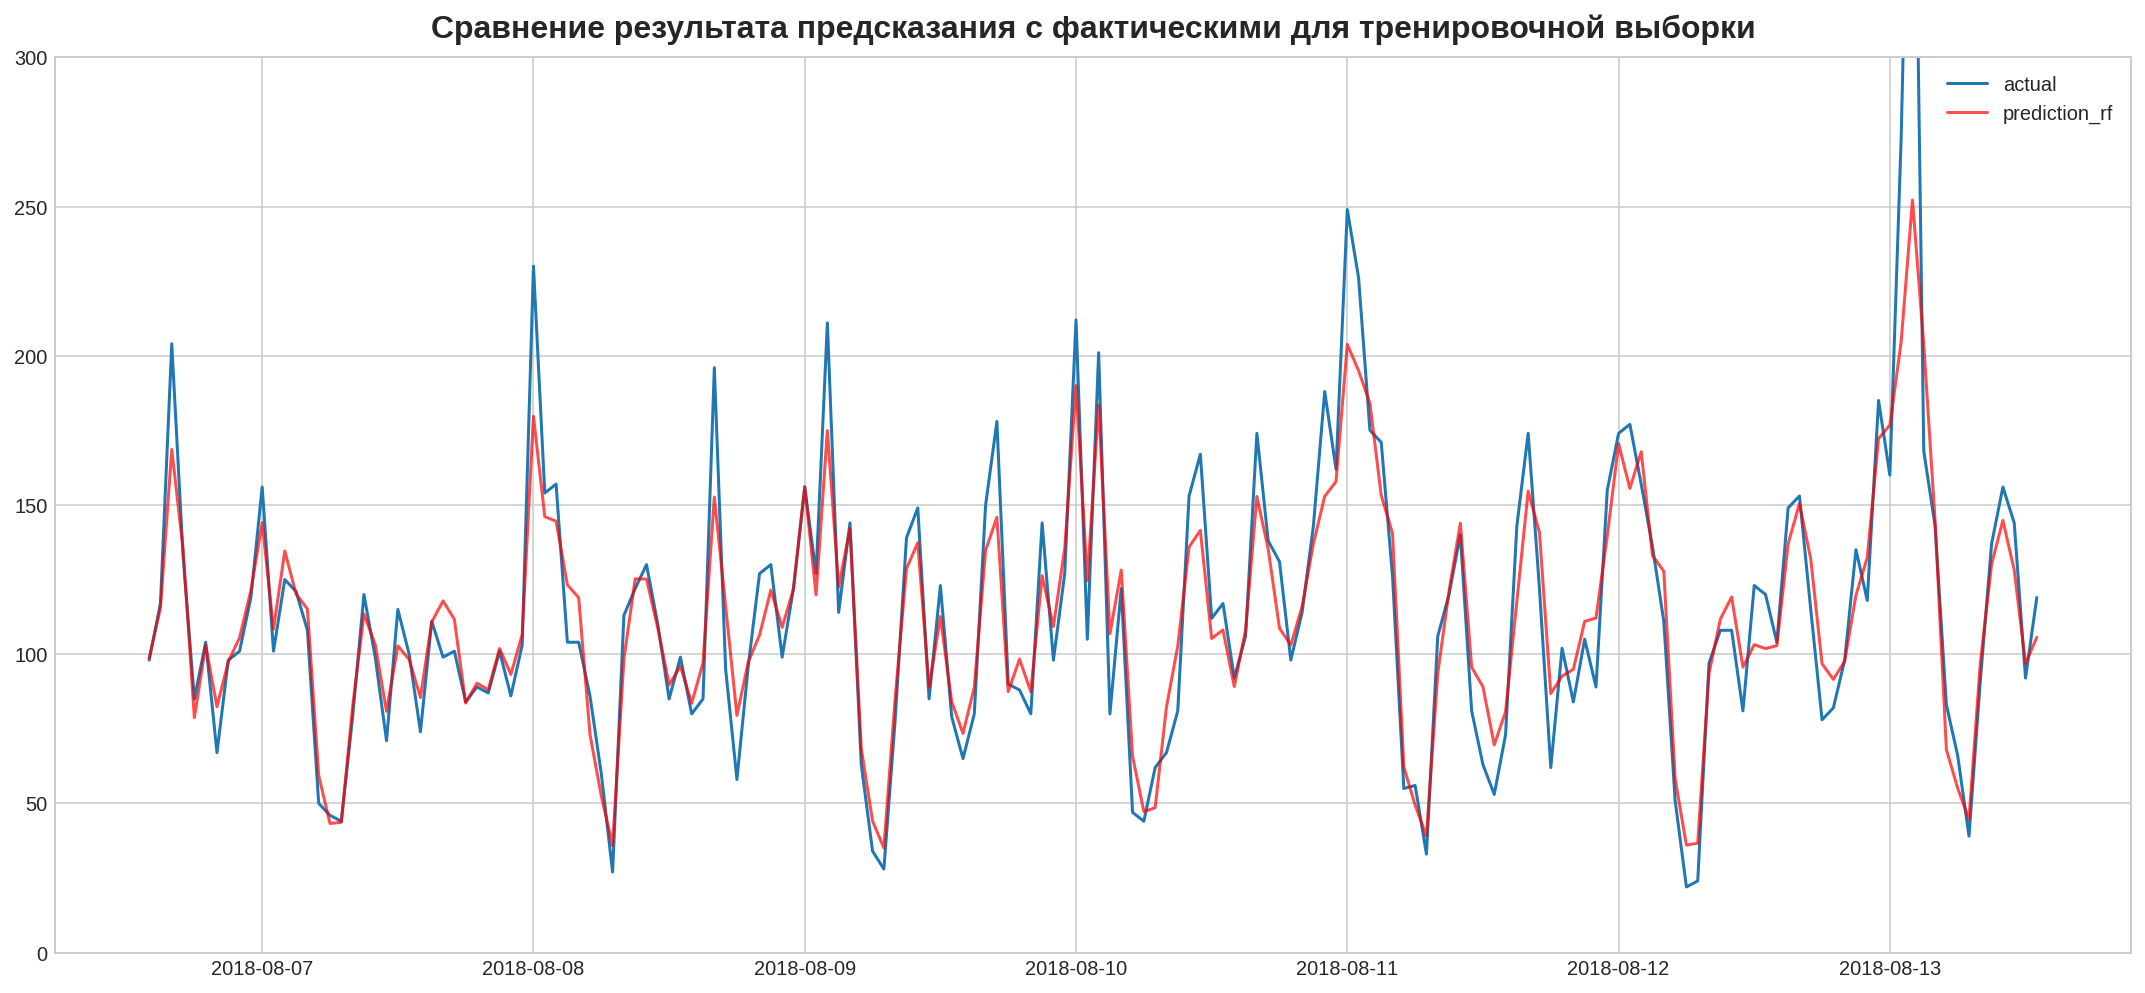

In [25]:
pred_train_rf = model_rf.predict(features_train)
tail = 24*7
plt.figure(figsize=(15, 7))
plt.plot(features_train.tail(tail).index, target_train.values[-tail:], label="actual")
plt.plot(features_train.tail(tail).index, pred_train_rf[-tail:], "r", label="prediction_rf", alpha=0.7)
plt.legend(loc="best")
plt.ylim(0,300)
plt.title("Сравнение результата предсказания с фактическими для тренировочной выборки")
plt.grid(True);

Как и метрика, визуально результат тоже стал больше похож на фактическое распределение по времени, модель лучше уловила суточные колебания заказов.

### LGBMRegressor

In [26]:
def tune_model_lgb(features, target):
    
    clf = LGBMRegressor(random_state=RANDOM_STATE)

    param = {}
    param['preprocessing'] =  [ None]
    param['classifier__n_estimators'] =  list(np.arange(1, 50, step=10)) + [None]
    param['classifier__max_depth'] = [-1, 2, 5, 10]
    param['classifier__learning_rate'] = [0.03, 0.1, 0.2]
    param['classifier__num_iterations'] = [20, 30 , 50]
    param['classifier'] = [clf]   

    pipeline = Pipeline([('preprocessing', None),
                         ('classifier', clf)])
    params = [param]
    
    cv = TimeSeriesSplit(n_splits=3) 
    grid =  RandomizedSearchCV(pipeline,
                               param_distributions=params,
                               scoring='neg_root_mean_squared_error',
                               n_iter=3,
                               cv=cv,
                               random_state=RANDOM_STATE,
                               refit=True,
                               verbose=3)

    grid.fit(features, target)

    print('Параметры наилучшей модели:')
    print("\n".join(f'{k} : {v}' for k,v in grid.best_params_.items()))
    print("Мера RMSE для наилучшей модели:", abs(grid.best_score_))

    return grid.best_estimator_, abs(grid.best_score_)

In [27]:
start = time.time()

model_lgb, rmse_lgb = tune_model_lgb(features_train, target_train)

end = time.time()
print('Время исполнения кода: ', time.strftime("%H:%M:%S",time.gmtime(end-start)))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END classifier=LGBMRegressor(random_state=12345), classifier__learning_rate=0.03, classifier__max_depth=10, classifier__n_estimators=41, classifier__num_iterations=30, preprocessing=None; total time=   7.8s
[CV 2/3] END classifier=LGBMRegressor(random_state=12345), classifier__learning_rate=0.03, classifier__max_depth=10, classifier__n_estimators=41, classifier__num_iterations=30, preprocessing=None; total time=  11.6s
[CV 3/3] END classifier=LGBMRegressor(random_state=12345), classifier__learning_rate=0.03, classifier__max_depth=10, classifier__n_estimators=41, classifier__num_iterations=30, preprocessing=None; total time=  14.8s
[CV 1/3] END classifier=LGBMRegressor(random_state=12345), classifier__learning_rate=0.1, classifier__max_depth=-1, classifier__n_estimators=None, classifier__num_iterations=50, preprocessing=None; total time=  16.2s
[CV 2/3] END classifier=LGBMRegressor(random_state=12345), classifier__learn

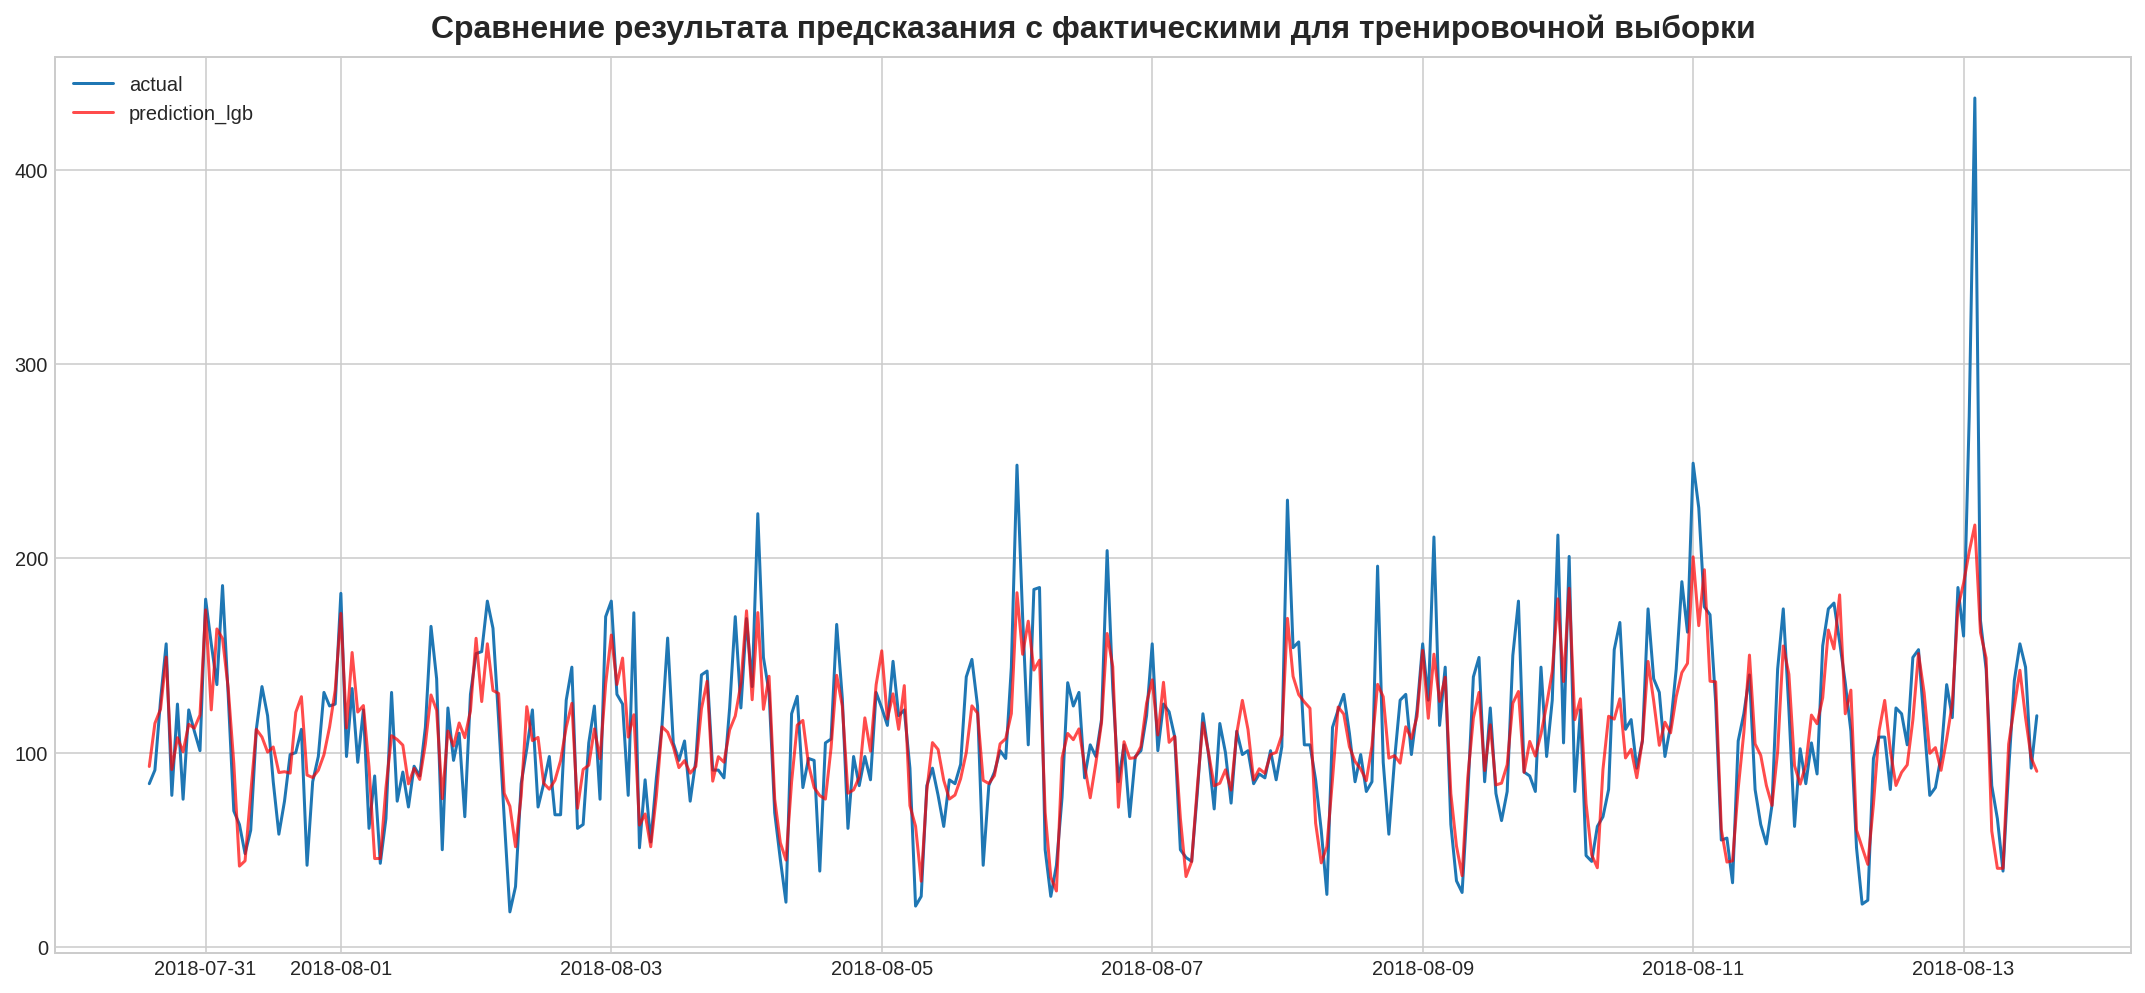

In [28]:
pred_train_lgb = model_lgb.predict(features_train)
tail = 24*7*2
plt.figure(figsize=(15, 7))
plt.plot(features_train.tail(tail).index, target_train.values[-tail:], label="actual")
plt.plot(features_train.tail(tail).index, pred_train_lgb[-tail:], "r", label="prediction_lgb", alpha=0.7)
plt.legend(loc="best")
plt.title("Сравнение результата предсказания с фактическими для тренировочной выборки")
plt.grid(True);

Мтрика получилась слегка лучше, чем у модели линейной регрессии и худше чем у случайного леса. Сравним еще раз результат работы трех моделей поближе:

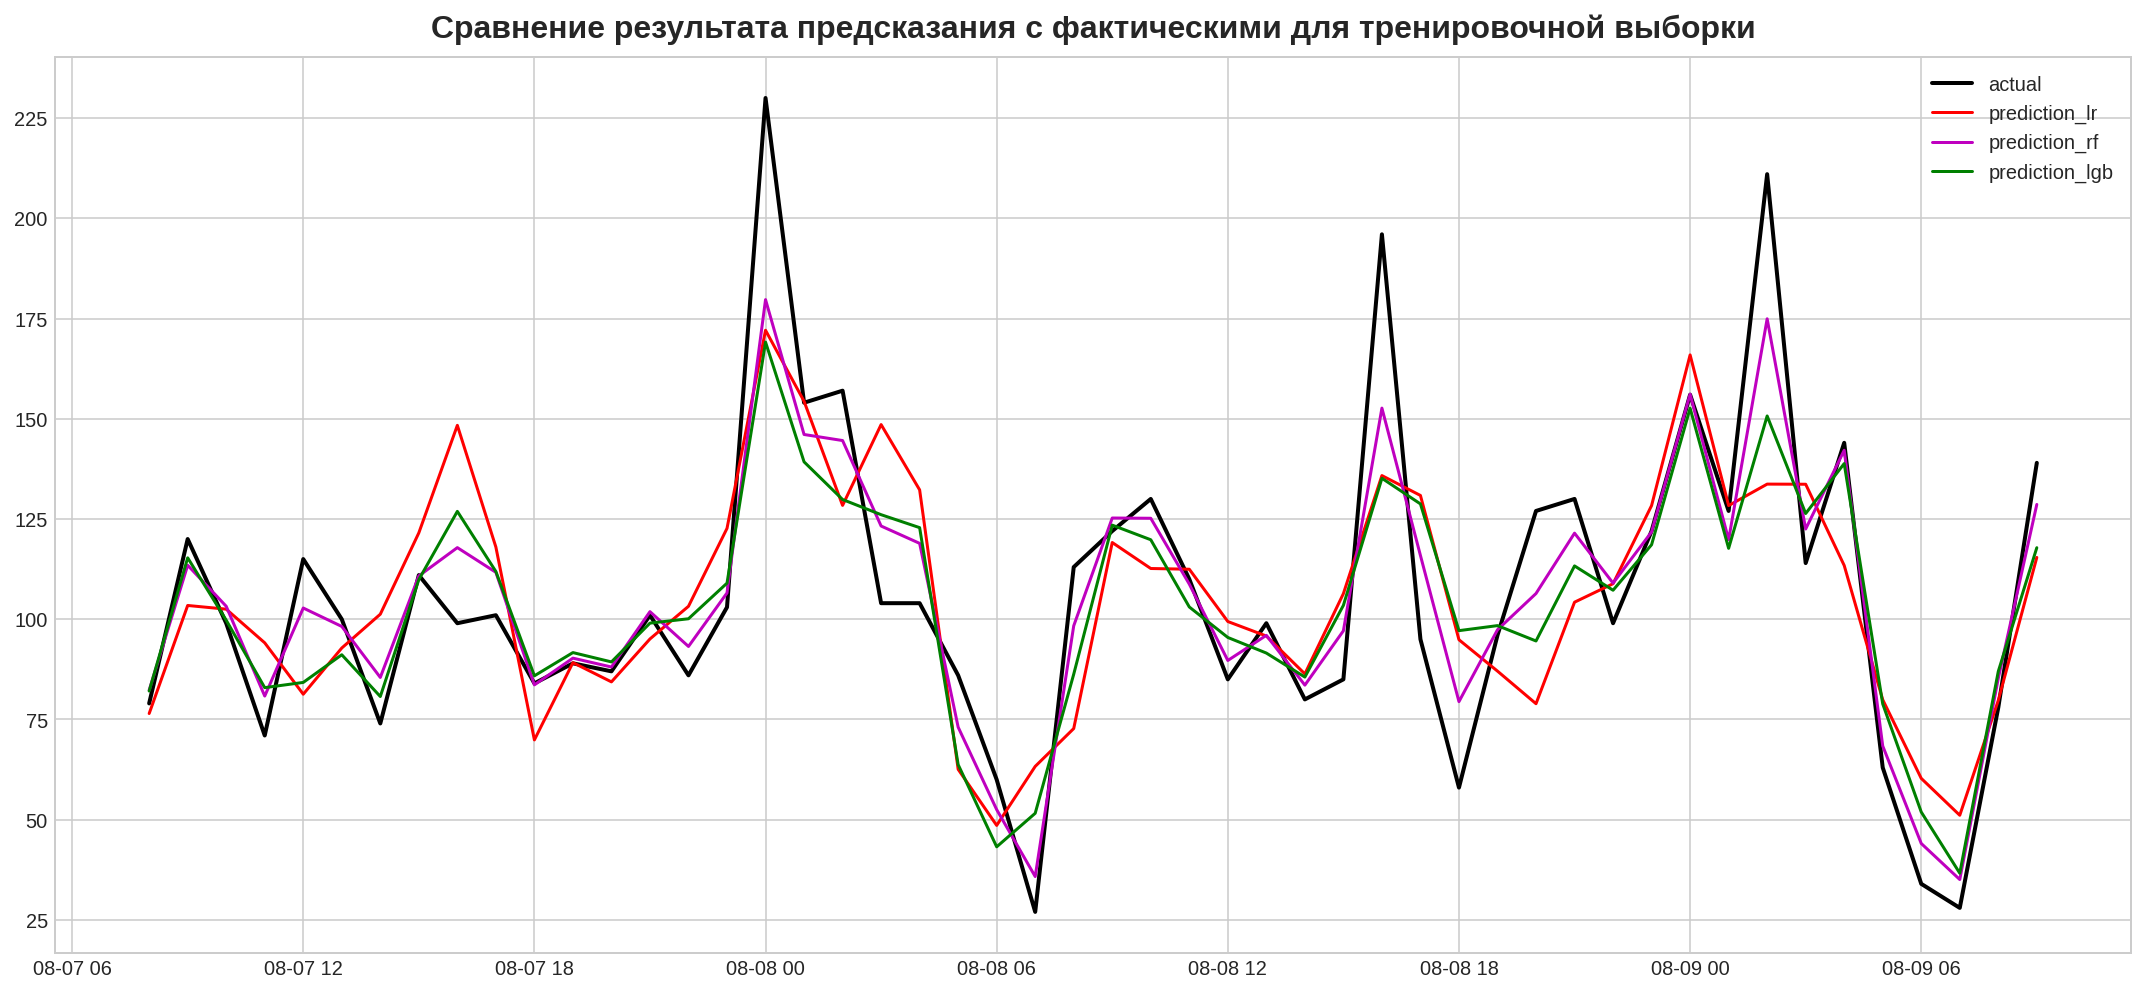

In [29]:
idx = [-150, -100]

plt.figure(figsize=(15, 7))
plt.plot(features_train.iloc[idx[0]:idx[1]].index, target_train.values[idx[0]:idx[1]],'k', label="actual", linewidth=2)
plt.plot(features_train.iloc[idx[0]:idx[1]].index, pred_train_lr[idx[0]:idx[1]], "r", label="prediction_lr")
plt.plot(features_train.iloc[idx[0]:idx[1]].index, pred_train_rf[idx[0]:idx[1]], "m", label="prediction_rf")
plt.plot(features_train.iloc[idx[0]:idx[1]].index, pred_train_lgb[idx[0]:idx[1]], "g", label="prediction_lgb")
plt.legend(loc="best")
plt.title("Сравнение результата предсказания с фактическими для тренировочной выборки")
plt.grid(True);

In [30]:
pd.DataFrame([rmse_lr, rmse_rf, rmse_lgb], columns=['RMSE'], index=['Линейная регрессия','Случайный лес','LGBMRegressor'])

,RMSE
Линейная регрессия,26.453226
Случайный лес,25.776037
LGBMRegressor,26.297638


Модель случайного леса и градиентного бустинга ведут себя очень похоже, модель линейной регрессии местами сильно отличается от моделей основанных на решающем дереве. При этом визульно, модели RF и LGB лучше улавливают локальные тренды спроса на такси, что может помочь при прогнозировании на новый временной промежуток. Учитывая вышесказанное, а так же значения метрики качества у трех моделей, в качестве лучшей модели предлагается выбрать модель случайного леса, показавшую метрику RMSE на тренировочной выборке - 25.8.

## Тестирование

Проверим выбранную модель случайного леса на тестовой выборке:

In [31]:
prediction = model_rf.predict(features_test)
print("RMSE на тестовой выборке:",  mean_squared_error(target_test, prediction)**0.5)


RMSE на тестовой выборке: 40.765826906113034


Полученная метрика больше чем на обучающей выборке. Однако это не удивительно, учитывая что тестовая выборка относится ко второй половине августа, когда было заметное увеличение количества заказов и присутствовали значительные выбросы, не характерные для остальных месяцев.

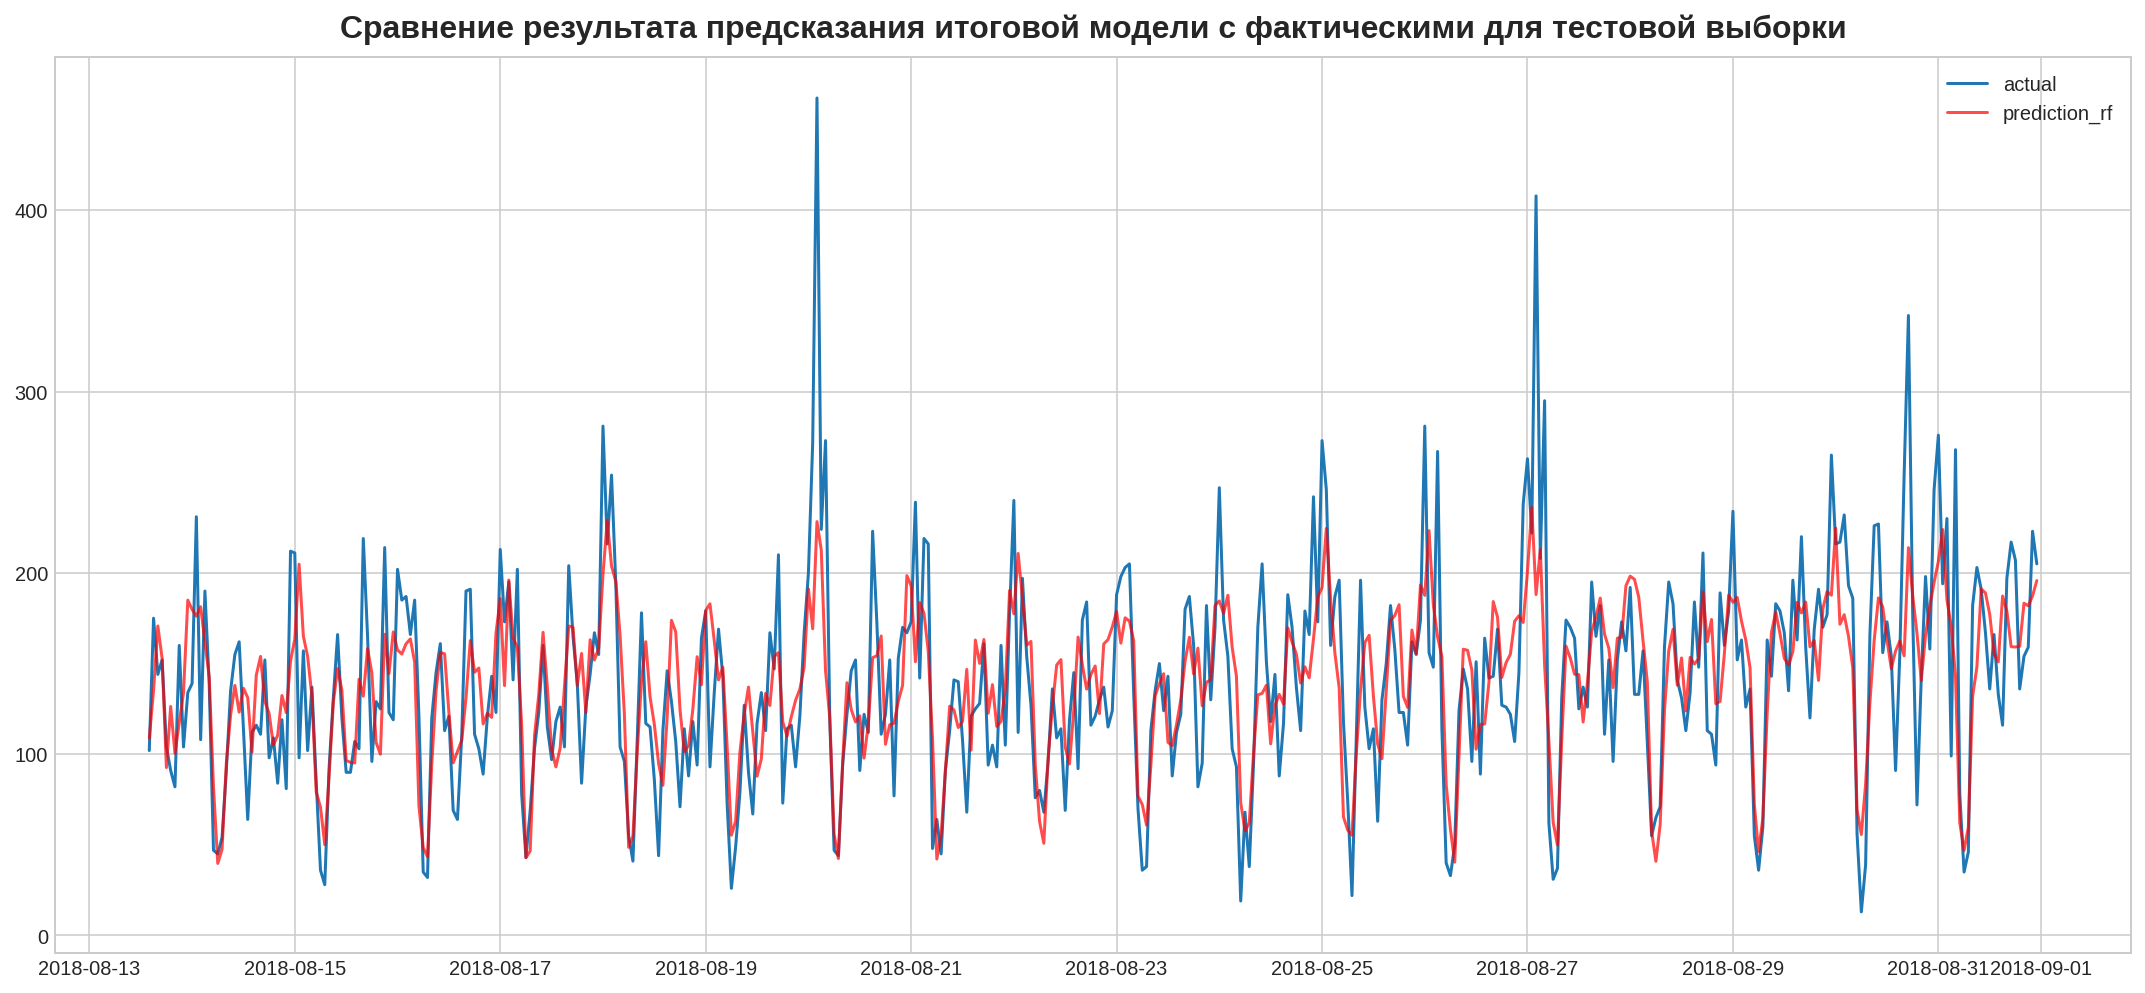

In [32]:
plt.figure(figsize=(15, 7))
plt.plot(features_test.index, target_test, label="actual")
plt.plot(features_test.index, prediction, "r", label="prediction_rf", alpha=0.7)
plt.legend(loc="best")
plt.title("Сравнение результата предсказания итоговой модели с фактическими для тестовой выборки")
plt.grid(True);

## Вывод

Перед нами стояла задача построить модель прогнозирующую количество заказов такси на следующий час для компании «Чётенькое такси». Для этого были исполльзованы исторические данные о заказах такси в аэропортах.
Данные были обработаны и проанализированы. Анализ показал заметную суточную и недельную сезонность в данных, а также тренд на возрастание количества заказов от марта к августу. 

На основе проведенного анализа были подготовлены дополнительные признаки для обучения моделей: календарные, отстающие признаки и скользящее среднее.

Для обучения были выбраны модели линейной регрессии, случайного леса и градиентного бустинга. Наилучшую метрику RMSE  на обучающей выборке показала модель случайного леса, наихудшую - линейной регрессии. Визуальное сравнение результатов моделей показала большую способность улавливать локальные суточные максимумы и минимумы у моделей случайного леса и градиентного бустинга. Учитывая что, модель будет использоваться для оценок периода пиковой нагрузки - в качестве итоговой была выбрана модель случайного леса. На тестовой выборке модель показала метрику RMSE равную 40.8, что удовлетворяет условию заказчика - значение метрики RMSE на тестовой выборке должно быть не больше 48.

Для дальнейшего улушения качества модели необходимо добавление данных за больший период времени - наша модель не способна предсказывать пиковые нагрузки в августовский период, поскольку обучается на данных других месяцев. Так же наиболее перспективным кажется включение дополнительной информации о количестве прилетов самолетов в аэропорт, для лушего прогнозирования выбросов в данных.